<a href="https://colab.research.google.com/github/Rocky12312/Poetry-generation/blob/master/langauge_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/My\ Drive/Poetry_generation

/content/drive/My Drive/Poetry_generation


In [0]:
import os
import re
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Reading the data from robert_frost.txt which contain poetry by Robert Frost including the most famous poems including "Road Not Taken"

In [0]:
#Will contain the text sequence which we gonna be treating as input
input_text = []
#Will contain the text sequence which gonna be treating as output
output_text = []
with open(os.path.join("robert_frost.txt")) as f:
  for line in f:
    line = line.rstrip()
    if not line:
      continue
    #As we know that input will have a start of sentence token <sos> token and output will have a end of sentence <eos> token
    input_line = "<sos> "+line
    output_line = line+" <eos>"
    #Appending the input in input_text and output in output_text which we will be using for the same purpose
    input_text.append(input_line)
    output_text.append(output_line)

In [0]:
#Defining the maximum_sequence_length
Max_sequence_length = 80
#Now joining both the input and output in corp
corp = input_text+output_text

In [6]:
from keras.preprocessing.text import Tokenizer
Max_vocab_size = 3000
tokenizer = Tokenizer(num_words = Max_vocab_size,filters = " ")
tokenizer.fit_on_texts(corp)
#Now converting the input and output sentences to sequences of integer using tokenizer
input_sequences = tokenizer.texts_to_sequences(input_text)
output_sequences = tokenizer.texts_to_sequences(output_text)

Using TensorFlow backend.


In [7]:
#Finding the maximum sequence length
Max_sequence_length_data = max(len(s) for s in input_sequences)
print("max_sequence_length_from_data: ",Max_sequence_length_data)

max_sequence_length_from_data:  12


In [8]:
#Utilizing word to index from tokenizer(actually in sequence each word has been mapped to a certain index which actually belong to word in vocabulary)
word2idx = tokenizer.word_index
print("Length_of_word_index: ",len(word2idx))
assert("<sos>" in word2idx)
assert("<eos>" in word2idx)

Length_of_word_index:  3056


In [0]:
max_sequence_length = min(Max_sequence_length,Max_sequence_length_data)
#Now padding the input and output sequences(padding will be post)
from keras.preprocessing.sequence import pad_sequences
padded_input_sequences = pad_sequences(input_sequences,maxlen = max_sequence_length,padding = "post")
padded_output_sequences = pad_sequences(output_sequences,maxlen = max_sequence_length,padding = "post")

Now basically what we have is input and output padded sequences

input sequences are vector of size 12 and so are output sequences and we have 1436 sample pair

Now we be loading our pretrained glove word embedding and we will transform each and every vector containing words in padded sequences with the word vectors from glove embeddings

In [10]:
#Here we will be using Glove word vectors
#First creating a dictonary of word to vectors(initializing a empty dictionary)
word2vec = {}
with open(os.path.join("glove.6B.100d.txt")) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype = "float32")
    word2vec[word] = vec
print("No of word to vectors in glove word 2 vec: ",len(word2vec))
#So here basically we created a dictionary having words as index and corresponding vectors as values

No of word to vectors in glove word 2 vec:  400000


Now next step which we gonna do is create a embedding matrix which we will use for mapping each of the word of our sentence to a vector 

In [0]:
#These num_words will be our vocabulary size
#Embedding_dim will be the size of our embeddings(word vectors), which will be 100 as in glove 100d each word contain a corresponding vector of 100d
#This plus 1 because word2idx index start from 1
num_words = min(Max_vocab_size,len(word2idx)+1)
Embedding_dim = 100
embedding_matrix = np.zeros((num_words,Embedding_dim))
for word,i in word2idx.items():
  if i<Max_vocab_size:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
#This is the way we gonna fill our embedding matrix with word vectors

One hot target can't use sparse cross_entropy

In [0]:
one_hot_targets = np.zeros((len(padded_input_sequences),max_sequence_length,num_words))
for i,target in enumerate(padded_output_sequences):
  for t,word in enumerate(target):
    if word>0:
      one_hot_targets[i,t,word] = 1

In [0]:
from keras.layers import Embedding
embedding_dim = 100
embedding_layer = Embedding(num_words,embedding_dim,weights = [embedding_matrix])

Now creating the model

In [0]:
from keras.models import Model
from keras.layers import Input,LSTM,Dense
#Defining the latent dim
M = 25
#For our model we will be having three inputs including the initail cell state and hidded state with input
input_ = Input(shape = (max_sequence_length,))
initial_h = Input(shape = (M,))
initial_c = Input(shape = (M,))
x = embedding_layer(input_)
#Return_sequence True as we have to preict the full sequence
lstm = LSTM(M,return_sequences = True,return_state = True)
x,_,_ = lstm(x,initial_state = [initial_h,initial_c])
dense = Dense(num_words,activation = "softmax")
output = dense(x)
#Inputs(input_,initail_h,initil_c) and Outputs(output)
model = Model([input_,initial_h,initial_c],output)

Thing to be given attention is that we have set return_state and return_sequences to be true so in our output we will be having output at each time stamp and return_state true will return both cell state and hidden state but if used GRU it will return only hidden state as thre is no cell state

In [0]:
#Now compiling the model
from keras.optimizers import Adam,SGD
model.compile(loss = "categorical_crossentropy",optimizer = Adam(lr = 0.01),metrics = ["accuracy"])

In [0]:
#Now defining the values of the initial hidden and cell state
val = np.zeros((len(padded_input_sequences),M))

In [17]:
#Fitting the model on the input and output data
ht = model.fit([padded_input_sequences,val,val],one_hot_targets,batch_size = 128,epochs = 200,validation_split = 0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1148 samples, validate on 288 samples
Epoch 1/200
1148/1148 [==============================] - 3s 2ms/step - loss: 5.3717 - accuracy: 0.0703 - val_loss: 5.0344 - val_accuracy: 0.0833
Epoch 2/200
1148/1148 [==============================] - 2s 2ms/step - loss: 4.5928 - accuracy: 0.0833 - val_loss: 4.7843 - val_accuracy: 0.0833
Epoch 3/200
1148/1148 [==============================] - 2s 2ms/step - loss: 4.3441 - accuracy: 0.0833 - val_loss: 4.8836 - val_accuracy: 0.0833
Epoch 4/200
1148/1148 [==============================] - 2s 2ms/step - loss: 4.2981 - accuracy: 0.0833 - val_loss: 4.8977 - val_accuracy: 0.0833
Epoch 5/200
1148/1148 [==============================] - 2s 2ms/step - loss: 4.2460 - accuracy: 0.0833 - val_loss: 4.9331 - val_accuracy: 0.0833
Epoch 6/200
1148/1148 [==============================] - 2s 2ms/step - loss: 4.2190 - accuracy: 0.0833 - val_loss: 4.9419 - val_accuracy: 0.0833
Epoch 7/200
1148/1148 [==============================] - 2s 2ms/step - loss: 4.1877

Plotting the accuracy and loss curve

As it is poetry so predicting the correct next word will always be hard here so accuracy will be impacted by this much

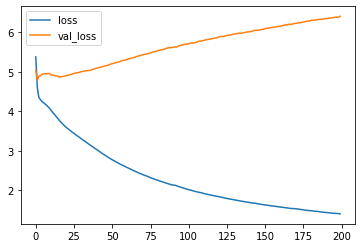

In [18]:
plt.plot(ht.history["loss"],label = "loss")
plt.plot(ht.history["val_loss"],label = "val_loss")
plt.legend()
plt.show()

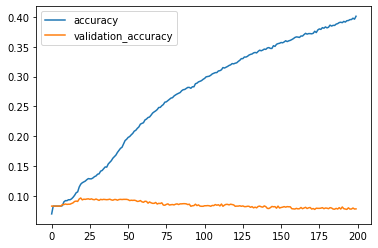

In [19]:
plt.plot(ht.history["accuracy"],label = "accuracy")
plt.plot(ht.history["val_accuracy"],label = "validation_accuracy")
plt.legend()
plt.show()

In [0]:
model.save("model_gen.h5")

Here what is happening is we are feding a input sentence and we are getting back the prediction for the next word all at same time and basically what we need is to make a model where we will feed a word at a time and will get prediction for it and then will feed the predicted word to get the new prediction of the next word and so on

Now we will build a model to which we will give a shape of 1 as input

In [0]:
input1 = Input(shape = (1,))
x = embedding_layer(input1)
x,h,c = lstm(x,[initial_h,initial_c])
output1 = dense(x)
model_x = Model([input1,initial_h,initial_c],[output1,h,c])

In [0]:
#Reversing the word2idx dictionary
idx2word = {v:k for k,v in word2idx.items()}

In [0]:
#THis sample line function gonna generate one line of output
def sample_line():
  #Defining the initial inputs
  #Initial word from starting will be the start of sentence token and initial cell state and initail hidden state will be vector of zeros
  np_input = np.array([[word2idx["<sos>"]]])
  h = np.zeros((1,M))
  c = np.zeros((1,M))
  eos = word2idx["<eos>"]
  #At each step after predicting the first word what we gonna do is input the current cell state and the hidden state from previous stamp
  #We will be storing the generate output sentences in outputs vector
  outputs = []
  for _ in range(max_sequence_length):
    #o is list of probablities for the next word
    o, h, c = model_x.predict([np_input,h,c])
    #It is very much possible to get a very high probablity for index 0 which generally doesn't correspond to any word
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("##")
    probs[0] = 0
    probs /= probs.sum()
    #Sampling the next word randomly
    idx = np.random.choice(len(probs),p=probs)
    if idx == eos:
      break
    #Output
    outputs.append(idx2word.get(idx,"<## %s>"%idx))
    #Next input the model will be the word predicted
    np_input[0,0] = idx
  return " ".join(outputs)

In [24]:
while True:
  #As we 4 line perverse in poetry so we will be generating 4 line at a time
  for _ in range(4):
    print(sample_line())
  
  ans = input("ppf generate another ")
  if ans and ans[0].lower().startswith("n"):
    break

now lupine ears settlement?
i see what they creaking i fade,
but smith, or someone, called them straight away
anyone else, but out of every emptied double trouble's
ppf generate another y
though not a grave down in trees and wet,
two standing to mind
to like the night all fresh
the only get they say had gone before i've brought you to
ppf generate another y
ppf generate another 
moisture and still be undone,
from that would have shifted has familiar spirits
if i mistrusted he found on the whole thing i stand together
'i only bewitched so mormon swimming or three?'
'i'm aftermath,
by picking the way of the cellar forty years ago as that?'
in garden upstairs in meeting of oil of make-believe,
what i see what they sometimes because to shelter alone he snapped
ppf generate another y
and scuttled just as well withdrawing laces
moisture and hold the ideals,
'i can help it.
good-looking books like that.' he was petered out,
ppf generate another n


The issue of accuracy is because the task is poetry generation and predicting next word in poetry is pretty difficult even for humans reading some previous poetry so same happens with algorithm